In [1]:
using LinearAlgebra
using SparseArrays

using ForwardDiff;
using NLsolve;
using LineSearches;

using Plots
using LaTeXStrings

using gmsh

# Define Permeability
The permeability is extracted from the datasheet of the core material (3C92) and fitted to an analytical expression.

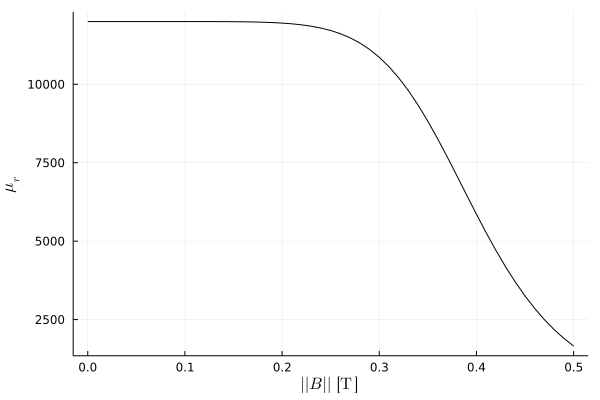

In [2]:
# Permeability function
a = 1 / 12000; 
b = 4;
c = 7.5;
mu0 = 4e-7 * pi;
fmur_core(B) = 1 / (a + (1 - a) * B^(2*b) / (B^(2*b) + c));

#a = 152.9e-3;
#b = 0.1071;
#fmur_core(B) = (b * max(B, 1e-3)) / (mu0 * sinh(max(B, 1e-3) / a));

B = Vector(0.:0.01:0.5);
plot(B, fmur_core.(B), color = :black, xlabel = L"||B||\,\mathrm{[T]}", ylabel = L"\mu_r", legend = false)

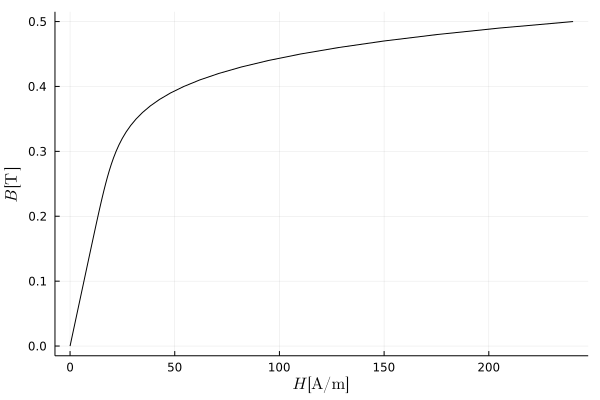

In [3]:
plot(B ./ (mu0 * fmur_core.(B)), B, color = :black, xlabel = L"H\,\mathrm{[A/m]}", ylabel = L"B\,\mathrm{[T]}", legend = false)

# Define Geometry

In [4]:
gmsh.finalize();
gmsh.initialize();

In [5]:
gmsh.open("geo/coil_geo.msh")

# Retrieve nodes from gmsh and sort in order of x-coords
node_ids, node_coord, _ = gmsh.model.mesh.getNodes()
xnode = node_coord[1:3:end];
p = sortperm(xnode);
x = xnode[p];
nids = node_ids[p];

Info    : Reading 'geo/coil_geo.msh'...
Info    : 15 entities
Info    : 114 nodes
Info    : 115 elements
Info    : Done reading 'geo/coil_geo.msh'


In [6]:
element_types, element_ids, element_connectivity = gmsh.model.mesh.getElements(1)
nelements = length(element_ids[1])

ngroup1 = gmsh.model.mesh.getNodesForPhysicalGroup(1, 1)
ngroup2 = gmsh.model.mesh.getNodesForPhysicalGroup(1, 2)
ngroup3 = gmsh.model.mesh.getNodesForPhysicalGroup(1, 3)
ngroup4 = gmsh.model.mesh.getNodesForPhysicalGroup(1, 4)
e_group = zeros(1,nelements)

for element_id in 1:nelements
    node1_id = element_connectivity[1][2*(element_id-1)+1]
    node2_id = element_connectivity[1][2*(element_id-1)+2]

    G1 = sum(node1_id.== ngroup1[1])+sum(node2_id.== ngroup1[1]) # Air
    G2 = sum(node1_id.== ngroup2[1])+sum(node2_id.== ngroup2[1]) # Core
    G3 = sum(node1_id.== ngroup3[1])+sum(node2_id.== ngroup3[1]) # Coil left
    G4 = sum(node1_id.== ngroup4[1])+sum(node2_id.== ngroup4[1]) # Coil right
    
    if G1 == 2
        e_group[element_id] = 1;
    elseif G2 == 2
        e_group[element_id] = 2;
    elseif G3 == 2
        e_group[element_id] = 3;
    elseif G4 == 2
        e_group[element_id] = 4;
    end
end

# Auxiliary Functions

In [7]:
function get_idx(node_id, nids)
    return findall(x -> x == node_id, nids)[1];
end

function bnd_dirichlet(idx, a, A, f)
    A[idx,:]   = zeros(length(f));
    A[idx,idx] = 1;
    f[idx] = a;
    
    return A, f;
end

bnd_dirichlet (generic function with 1 method)

# Linear Elements

In [8]:
#..Set the source function 
J = 2.2e4;
fsource(group_id) = J * (group_id == 3) - J * (group_id == 4);
fsource_elem = map(fsource, e_group);

# Permittivity and reluctivity
mu0 = 4e-7 * pi;
fmu(group_id, B) = mu0 + (fmur_core(B) - 1) * mu0 * (group_id == 2);
fnu(group_id, B) = 1 / fmu(group_id, B);

In [9]:
# Collect points (left and right nodes for each element) and edges (connectivity: indices of left and right nodes)
points = collect( [x[i], x[i+1]] for i in 1:length(x)-1) 
edges = collect( [i, i+1] for i in 1:length(x)-1); 

function assemble_matrices(u) 
    #..Initialize global matrix and right-hand side value 
    A = zeros(eltype(u), length(x), length(x)); 
    f = zeros(length(x)); 
    
    B = abs.(diff(u) ./ diff(x));
    fnu_elem = map(fnu, e_group, B);

    #..Perform loop over elements and assemble global matrix and vector 
    for i=1:length(edges) 
        xl, xr = points[i,:][1]
        h = xr - xl;

        floc = h/2 * [1; 1] * fsource_elem[i];
        Aloc = fnu_elem[i] / h * [1 -1; -1 1];
        
        f[edges[i]] += floc;
        A[edges[i], edges[i]] += Aloc;
    end

    #..handle the boundary conditions in the matrix and right-hand side vector 
    A, f = bnd_dirichlet(get_idx(1, nids), 0, A, f);    # Boundary at x = 0
    A, f = bnd_dirichlet(get_idx(8, nids), 0, A, f);    # Boundary at x = 1
    
    return A, f;
end

function res!(R, u)
    A, f = assemble_matrices(u);
    R[:] = A * u - f;
end

res! (generic function with 1 method)

In [10]:
A0, f0 = assemble_matrices(zeros(size(x)))
ulin = A0 \ f0;

results = nlsolve(res!, ulin, autodiff = :forward, show_trace = :true)
u = results.zero;

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.031199e+06              NaN
     1     2.546769e+02     4.154841e-01
     2     3.031199e+06     1.694066e-21
     3     3.031199e+06     0.000000e+00
     4     1.455784e+06     0.000000e+00
     5     6.502922e+04     1.694066e-21
     6     1.159368e+02     5.193554e-02
     7     2.380523e+01     3.297684e-03
     8     9.462697e-01     5.803010e-04
     9     1.668631e-03     2.513554e-05
    10     5.614808e-09     4.502567e-08


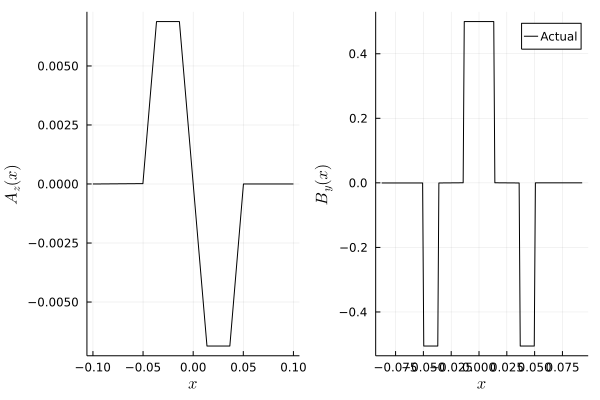

In [11]:
# Post-processing
xmid = diff(x) / 2 + x[1:end-1];
ux = diff(u) ./ diff(x);

# Plot
p1 = plot(x, u, xlabel = L"x", ylabel = L"A_z(x)", color = :black, lw = 1, legend = false);
p2 = plot(xmid, -ux, xlabel = L"x", ylabel = L"B_y(x)", color = :black, lw = 1, legend = false);

plot(p1, p2)

# Linear Elements & Eddy Currents

In [12]:
#..Set the source function 
J = 2.2e4;
fsource(group_id) = J * (group_id == 3) - J * (group_id == 4);
fsource_elem = map(fsource, e_group);

# Permittivity and reluctivity
mu0 = 4e-7 * pi;
fmu(group_id, B) = mu0 + (fmur_core(B) - 1) * mu0 * (group_id == 2);
fnu(group_id, B) = 1 / fmu(group_id, B);

sigma_core = 1e2;
fsigma(group_id) = sigma_core * (group_id == 2);
fsigma_elem = map(fsigma, e_group)

f     = 0.2e6;
omega = 2*pi*f;

In [13]:
# Collect points (left and right nodes for each element) and edges (connectivity: indices of left and right nodes)
points = collect( [x[i], x[i+1]] for i in 1:length(x)-1) 
edges = collect( [i, i+1] for i in 1:length(x)-1); 

function assemble_matrices(u) 
    #..Initialize global matrix and right-hand side value 
    A = zeros(eltype(u), length(x), length(x)); 
    f = zeros(length(x)); 
    
    B = abs.(diff(u) ./ diff(x));
    fnu_elem = map(fnu, e_group, B);

    #..Perform loop over elements and assemble global matrix and vector 
    for i=1:length(edges) 
        xl, xr = points[i,:][1]
        h = xr - xl;

        floc = h/2 * [1; 1] * fsource_elem[i];
        Aloc = fnu_elem[i] / h * [1 -1; -1 1] + 1im * omega * fsigma_elem[i] * [1/3 1/6; 1/6 1/3] * h;
        
        f[edges[i]] += floc;
        A[edges[i], edges[i]] += Aloc;
    end

    #..handle the boundary conditions in the matrix and right-hand side vector 
    A, f = bnd_dirichlet(get_idx(1, nids), 0, A, f);    # Boundary at x = 0
    A, f = bnd_dirichlet(get_idx(8, nids), 0, A, f);    # Boundary at x = 1
    
    return A, f;
end

function res!(R, u)
    A, f = assemble_matrices(u);
    R[:] = A * u - f;
end

res! (generic function with 1 method)

In [14]:
ForwardDiff.can_dual(::Type{ComplexF64}) = true

A0, f0 = assemble_matrices(0 * ones(Complex{Float64}, size(x)))
ulin = A0 \ f0;

ls = BackTracking(order = 3)
results = nlsolve(res!, ulin, autodiff = :finite, method = :newton, linesearch = ls, show_trace = :true)
u = results.zero;

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.892042e+06              NaN
     1     2.836953e+03     2.440952e-04
     2     2.515067e+03     2.329369e-06
     3     2.227595e+03     1.962623e-07
     4     1.109320e+03     6.333102e-06
     5     3.302487e+02     2.186846e-07
     6     2.453489e+02     9.976633e-08
     7     2.013263e+02     2.592016e-06
     8     4.737413e+01     1.691945e-08
     9     2.528237e+01     5.044636e-08
    10     2.080675e+01     5.436241e-10
    11     1.562086e+01     8.189523e-10
    12     1.167449e+01     1.342720e-08
    13     8.416305e+00     2.837988e-09
    14     7.908477e+00     2.697960e-09
    15     5.608849e+00     1.949855e-09
    16     6.154061e+00     1.587539e-09
    17     4.510173e+00     1.231714e-09
    18     4.959018e+00     1.023913e-09
    19     3.796415e+00     8.173512e-10
    20     4.067501e+00     6.878128e-10
    21     3.215298e+00     5.587812e-10
    22     3.37165

   249     3.619616e-08     5.841916e-26
   250     3.348896e-08     5.002496e-26
   251     3.075962e-08     4.242944e-26
   252     2.838215e-08     3.611813e-26
   253     2.641397e-08     3.044255e-26
   254     2.484113e-08     2.572251e-26
   255     2.308444e-08     2.288592e-26
   256     2.111677e-08     1.993833e-26
   257     1.935321e-08     1.681591e-26
   258     1.755663e-08     1.428717e-26
   259     1.600580e-08     1.157441e-26
   260     1.490146e-08     9.723666e-27
   261     1.388158e-08     8.253425e-27
   262     1.287821e-08     6.988161e-27
   263     1.192277e-08     6.175351e-27
   264     1.112534e-08     5.387517e-27
   265     1.029645e-08     4.652623e-27
   266     9.392930e-09     3.824029e-27


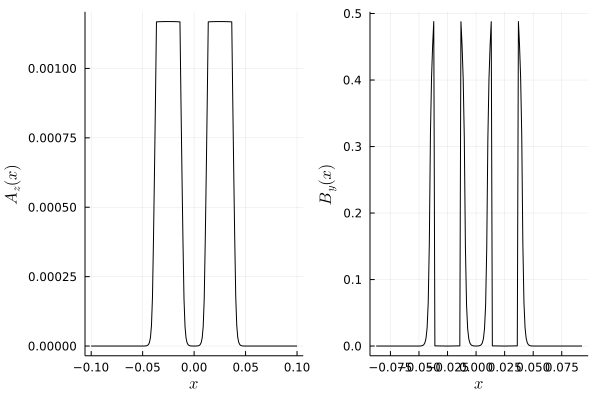

In [15]:
# Post-processing
xmid = diff(x) / 2 + x[1:end-1];
ux = diff(u) ./ diff(x);

# Plot
p1 = plot(x, norm.(u), xlabel = L"x", ylabel = L"A_z(x)", color = :black, lw = 1, legend = false);
p2 = plot(xmid, norm.(ux), xlabel = L"x", ylabel = L"B_y(x)", color = :black, lw = 1, legend = false);

plot(p1, p2)

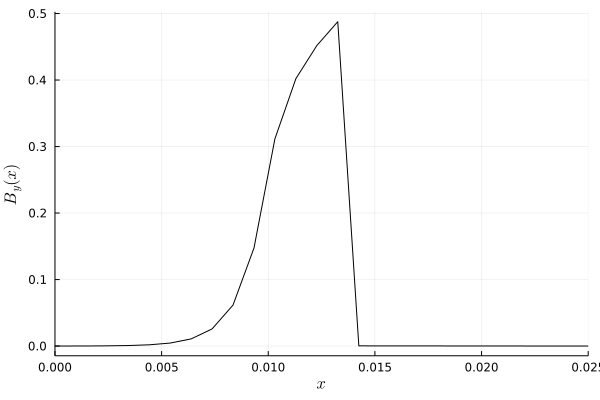

In [16]:
plot(xmid, norm.(ux), xlabel = L"x", ylabel = L"B_y(x)", color = :black, lw = 1, legend = false)
xlims!((0, 0.025))

# Quadratic Elements & Eddy Currents

In [17]:
#..Set the source function 
J = 2.2e4;
fsource(group_id) = J * (group_id == 3) - J * (group_id == 4);
fsource_elem = map(fsource, e_group);

# Permittivity and reluctivity
mu0 = 4e-7 * pi;
fmu(group_id, B) = mu0 + (fmur_core(B) - 1) * mu0 * (group_id == 2);
fnu(group_id, B) = 1 / fmu(group_id, B);

sigma_core = 1e2;
fsigma(group_id) = sigma_core * (group_id == 2);
fsigma_elem = map(fsigma, e_group)

f     = 0.2e6;
omega = 2*pi*f;

In [18]:
# Collect points (left and right nodes for each element) and edges (connectivity: indices of left and right nodes)
Na = 2 * length(x) - 1;
points = collect( [x[i], 0.5*(x[i] + x[i+1]), x[i+1]] for i in 1:length(x)-1) 
edges = collect( [i, i+1, i+2] for i in 1:2:Na-1); 

X = collect([points[i][1], points[i][2]] for i in 1:length(points))
X = reduce(vcat, X);
X = vcat(X, x[end]);

function assemble_matrices(u) 
    #..Initialize global matrix and right-hand side value 
    A = zeros(eltype(u), Na, Na); 
    B = zeros(Na);
    f = zeros(Na);
    
    # Calculate magnetic flux density
    Emat = 2 * [2, -4, 2] * [0 0.5 1] .+ [-3, 4, -1];
    for i=1:length(edges) 
        xl, xm, xr = points[i,:][1];
        ul, um, ur = u[edges[i]];

        dux  = [ul um ur] * Emat / (xr - xl);
        B[i] = norm.(dux[2]);
    end
    
    fnu_elem = map(fnu, e_group, B);

    #..Perform loop over elements and assemble global matrix and vector 
    for i=1:length(edges) 
        xl, xm, xr = points[i,:][1];
        h = xr - xl;

        floc = h/6 * [1; 4; 1] * fsource_elem[i];
        Aloc = fnu_elem[i] * [7 -8 1; -8 16 -8; 1 -8 7] / (3 * h) + 1im * omega * fsigma_elem[i] * [2/15 1/15 1/30; 1/15 8/15 -1/15; 1/30 -1/15 2/15] * h; 

        f[edges[i]] += floc;
        A[edges[i], edges[i]] += Aloc;
    end

    #..handle the boundary conditions in the matrix and right-hand side vector 
    A[1,:]   = zeros(Na);  A[1,1]     = 1;      f[1]   = 0;
    A[end,:] = zeros(Na);  A[end,end] = 1;      f[end]   = 0;
    
    return A, f;
end

function res!(R, u)
    A, f = assemble_matrices(u);
    R[:] = A * u - f;
end

res! (generic function with 1 method)

In [19]:
#ForwardDiff.can_dual(::Type{ComplexF64}) = true

A0, f0 = assemble_matrices(zeros(Complex{Float64}, Na))
ulin = A0 \ f0;

ls = BackTracking(order = 3)
results = nlsolve(res!, ulin, autodiff = :finite, method = :newton, linesearch = ls, show_trace = :true)
u = results.zero;

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.604556e+06              NaN
     1     3.356841e+04     4.697379e-04
     2     1.501570e+04     5.493090e-06
     3     1.588868e+03     3.190767e-06
     4     3.084544e+02     1.235825e-05
     5     2.782827e+02     4.774761e-07
     6     2.510474e+02     3.848252e-07
     7     2.249205e+02     3.078036e-07
     8     1.953265e+02     1.919087e-07
     9     1.536816e+02     8.901826e-08
    10     3.761925e+01     8.116404e-07
    11     2.703766e+01     1.021603e-07
    12     2.177488e+01     1.598434e-09
    13     1.361203e+01     4.631321e-09
    14     1.189114e+01     1.789627e-08
    15     9.486912e+00     7.398139e-09
    16     8.131707e+00     9.089063e-10
    17     6.984118e+00     7.273468e-10
    18     5.928964e+00     3.561798e-10
    19     5.125880e+00     2.583178e-10
    20     4.447966e+00     1.849806e-10
    21     3.856685e+00     1.337148e-10
    22     3.34107

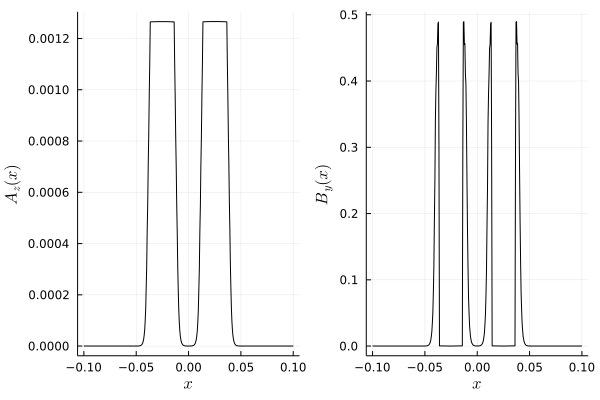

In [20]:
# Post-processing
ux    = zeros(Complex{Float64}, Na);
Jeddy = zeros(Complex{Float64}, Na);

Emat = 2 * [2, -4, 2] * [0 0.5 1] .+ [-3, 4, -1];
for i=1:length(edges) 
    xl, xm, xr = points[i,:][1];
    ul, um, ur = u[edges[i]];
    
    dux = [ul um ur] * Emat / (xr - xl);
    
    ux[edges[i]] += [dux[1]/2; dux[2]; dux[3]/2];
    
    Jeddy[edges[i]] += 1im * omega * fsigma_elem[i] * [ul/2 um ur/2]';
end

# Plot
p1 = plot(X, norm.(u), xlabel = L"x", ylabel = L"A_z(x)", color = :black, lw = 1, legend = false);
p2 = plot(X, norm.(ux), xlabel = L"x", ylabel = L"B_y(x)", color = :black, lw = 1, legend = false);

plot(p1, p2)

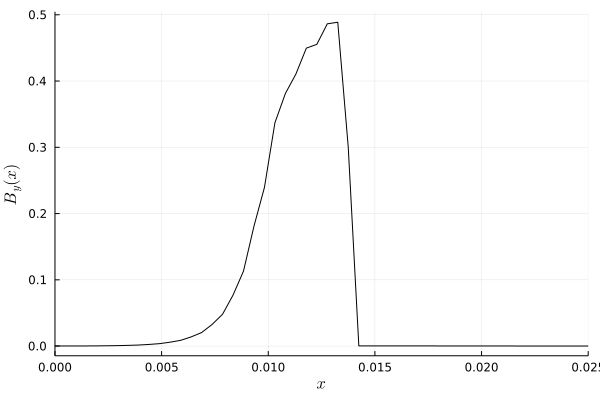

In [21]:
plot(X, norm.(ux), xlabel = L"x", ylabel = L"B_y(x)", color = :black, lw = 1, legend = false)
xlims!((0, 0.025))

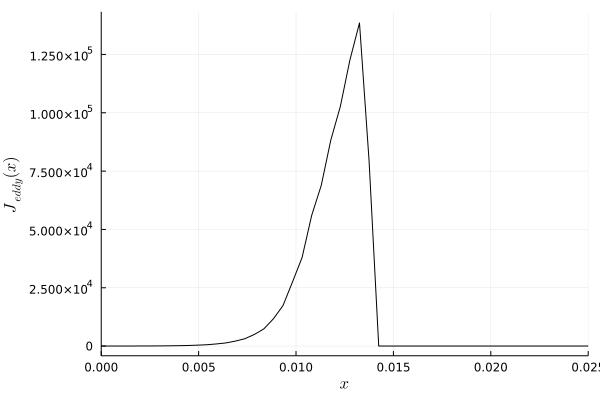

In [22]:
plot(X, norm.(Jeddy), xlabel = L"x", ylabel = L"J_{eddy}(x)", color = :black, lw = 1, legend = false)
xlims!((0, 0.025))